-----
<h1 style="color: #191970; font-weight: bold; text-align: center;">MINI CASE PYSPARK - Jump Start</h1>
<h4 style="font-style: italic; text-align: center;">Nayara de Oliveira Brabo</h4>
<p style="font-style: italic; text-align: center;">31/07/2024</p>

-----

<p>Vocês devem escolher uma questão do case pandas, refazer utilizando pyspark.</p>

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, FloatType
from pyspark.sql.functions import regexp_replace, col, when, format_number, row_number
from pyspark.sql import Window

<h2 style='color: #191970; font-weight: bold; text-align: center;'>SESSÃO PYSPARK</h2>

In [4]:
spark = SparkSession.builder.appName('Spark').getOrCreate()

-----

<h2 style='color: #191970; font-weight: bold; text-align: center;'>IMPORTANDO OS DATAFRAMES</h2>

<h2 style='color: #191970; font-weight: bold; text-align: center;">IMPORTANDO AS BASES DE DADOS</h2>

<h5 style="color: #191970; font-weight: bold; font-size: 18px;">TITLE BASICS - Descrição dos Campos</h5>

<style>
    ul {
        list-style-type: none;
        padding: 0;
    }
    li {
        margin: 10px 0;
        font-size: 14px;
    }
    li::before {
        content: "> ";
        color: #191970;
        font-weight: bold;
    }
</style>

<ul>
    <li><strong>tconst (string)</strong> - identificador alfanumérico único do título</li>
    <li><strong>titleType (string)</strong> – o tipo/formato do título (ex.: filme, curta, série de TV, episódio de TV, vídeo, etc.)</li>
    <li><strong>originalTitle (string)</strong> – o título original / No idioma original</li>
    <li><strong>primaryTitle (string)</strong> – o título mais popular / o título usado pelos cineastas em materiais promocionais no momento do lançamento</li>
    <li><strong>startYear (YYYY)</strong> – representa o ano de lançamento de um título. No caso de séries de TV, é o ano de início da série</li>
    <li><strong>runtimeMinutes</strong> – duração principal do título, em minutos</li>
    <li><strong>genres (array de strings)</strong> – inclui até três gêneros associados ao título</li>
</ul>


- Importar a base de dados

In [5]:
path = r'C:\Users\nayar\Documents\START\CASE_python\database\title.basics.tsv'

parametros = {
    'delimiter': '\t', 
    'header': True,
}

df_basics = spark.read.options(**parametros).csv(path)

- Filtrar apenas o que é considerado filme:
    - movie
    - tvMovie
    - short
    - tvShort
- Filtrar apenas os títulos que não estão vazios
- Filtrar apenas os filmes com startYear < 2024

In [6]:
df_basics = df_basics.filter(df_basics['titleType'].isin('movie', 'tvMovie', 'short', 'tvShort'))

In [7]:
# Filtrar titulo em branco
df_basics = df_basics.dropna(subset=['originalTitle'])

In [8]:
# Filtrar ano de estreia < 2024
df_basics = df_basics.filter(df_basics['startYear'] <= 2024)

In [9]:
df_basics.show()

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|tt0000001|    short|          Carmencita|          Carmencita|      0|     1894|     \N|             1|   Documentary,Short|
|tt0000002|    short|Le clown et ses c...|Le clown et ses c...|      0|     1892|     \N|             5|     Animation,Short|
|tt0000003|    short|      Pauvre Pierrot|      Pauvre Pierrot|      0|     1892|     \N|             5|Animation,Comedy,...|
|tt0000004|    short|         Un bon bock|         Un bon bock|      0|     1892|     \N|            12|     Animation,Short|
|tt0000005|    short|    Blacksmith Scene|    Blacksmith Scene|      0|     1893|     \N|             1|        Comedy

- Criar coluna com a categoria de duração do filme

<style>
    ul {
        list-style-type: none;
        padding: 0;
    }
    li {
        margin: 10px 0;
        font-size: 14px;
    }
    li::before {
        content: '> ';
        color: #191970;
        font-weight: bold;
    }
</style>

<p>Segundo a ancine:</p> 
<ul>
    <li><strong>curta-metragem</strong> - aquela cuja duração é igual ou inferior a quinze minutos;</li>
    <li><strong>média-metragem</strong> – aquela cuja duração é superior a quinze minutos e igual ou inferior a setenta minutos;</li>
    <li><strong>longa-metragem</strong> – aquela cuja duração é superior a setenta minutos.</li>
</ul>


In [31]:
df_basics = df_basics.withColumn(
    'categoria_duracao',
    when((col('runtimeMinutes') == '\\N') | (col('runtimeMinutes') == 0), 'sem dados')
    .when(col('runtimeMinutes') <= 15, 'curta-metragem')
    .when((col('runtimeMinutes') > 15) & (col('runtimeMinutes') <= 70), 'media-metragem')
    .otherwise('longa-metragem')
)

In [32]:
df_basics.show()

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+-----------------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|categoria_duracao|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+-----------------+
|tt0000001|    short|          Carmencita|          Carmencita|      0|     1894|     \N|             1|         Documentary|   curta-metragem|
|tt0000002|    short|Le clown et ses c...|Le clown et ses c...|      0|     1892|     \N|             5|           Animation|   curta-metragem|
|tt0000003|    short|      Pauvre Pierrot|      Pauvre Pierrot|      0|     1892|     \N|             5|Animation,Comedy,...|   curta-metragem|
|tt0000004|    short|         Un bon bock|         Un bon bock|      0|     1892|     \N|            12|           Animation|   curta-me

In [12]:
# Remover o genero short
df_basics = df_basics.withColumn(
    'genres',
    regexp_replace(col('genres'), r'(^|,\s*)Short', '')
)

# Remover vírgula no início ou no final, se houver
df_basics = df_basics.withColumn(
    'genres',
    regexp_replace(col('genres'), r'^,|,$', '')  # Remove vírgula no início ou no final
)

# Filtrar genero em branco
df_basics = df_basics.filter((col('genres').isNotNull()) & (col('genres') != ''))

In [13]:
df_basics.show(20, False)

+---------+---------+-------------------------------------------+-------------------------------------------------+-------+---------+-------+--------------+------------------------+-----------------+
|tconst   |titleType|primaryTitle                               |originalTitle                                    |isAdult|startYear|endYear|runtimeMinutes|genres                  |categoria_duracao|
+---------+---------+-------------------------------------------+-------------------------------------------------+-------+---------+-------+--------------+------------------------+-----------------+
|tt0000001|short    |Carmencita                                 |Carmencita                                       |0      |1894     |\N     |1             |Documentary             |curta-metragem   |
|tt0000002|short    |Le clown et ses chiens                     |Le clown et ses chiens                           |0      |1892     |\N     |5             |Animation               |curta-metragem   |


<h4 style="font-weight: bold; text-align: center;">-----------------------------------</h4>

<h5 style="color: #191970; font-weight: bold; font-size: 18px;">TITLE RATINGS - Descrição dos Campos</h5>

<style>
    ul {
        list-style-type: none;
        padding: 0;
    }
    li {
        margin: 10px 0;
        font-size: 14px;
    }
    li::before {
        content: "> ";
        color: #191970;
        font-weight: bold;
    }
</style>

<ul>
    <li><strong>tconst (string)</strong> - identificador alfanumérico único do título</li>
    <li><strong>averageRating</strong> – média ponderada de todas as classificações individuais dos usuários</li>
    <li><strong>numVotes</strong> - número de votos que o título recebeu</li>
</ul>


In [14]:
path2 = r'C:\Users\nayar\Documents\START\CASE_python\database\title.ratings.tsv'

parametros = {
    'delimiter': '\t', 
    'header': True
}

df_ratings = spark.read.options(**parametros).csv(path2)

<h4 style="font-weight: bold; text-align: center;">-----------------------------------</h4>

<h5 style="color: #191970; font-weight: bold; font-size: 18px;">MESCLANDO OS DF: TITLE.BASICS COM O TITLE.RATINGS</h5>

<style>
    ul {
        list-style-type: none;
        padding: 0;
    }
    li {
        margin: 10px 0;
        font-size: 14px;
    }
    li::before {
        content: "> ";
        color: #191970;
        font-weight: bold;
    }
</style>

<ul>
    <li><strong>tconst (string)</strong> - identificador alfanumérico único do título</li>
    <li><strong>titleType (string)</strong> – o tipo/formato do título (ex.: filme, curta, série de TV, episódio de TV, vídeo, etc.)</li>
    <li><strong>primaryTitle (string)</strong> – o título mais popular / o título usado pelos cineastas em materiais promocionais no momento do lançamento</li>
    <li><strong>isAdult (booleano)</strong> - 0: título não adulto; 1: título adulto</li>
    <li><strong>startYear (YYYY)</strong> – representa o ano de lançamento de um título. No caso de séries de TV, é o ano de início da série</li>
    <li><strong>runtimeMinutes</strong> – duração principal do título, em minutos</li>
    <li><strong>genres (array de strings)</strong> – inclui até três gêneros associados ao título</li>
    <li><strong>averageRating</strong> – média ponderada de todas as classificações individuais dos usuários</li>
    <li><strong>numVotes</strong> - número de votos que o título recebeu</li>
</ul>


In [15]:
df_basics_ratings = df_basics.join(
    df_ratings, 
    on='tconst', 
    how='left'
)

In [16]:
df_basics_ratings.show()

+----------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+-----------------+-------------+--------+
|    tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|categoria_duracao|averageRating|numVotes|
+----------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+-----------------+-------------+--------+
| tt0000002|    short|Le clown et ses c...|Le clown et ses c...|      0|     1892|     \N|             5|           Animation|   curta-metragem|          5.6|     279|
| tt0000004|    short|         Un bon bock|         Un bon bock|      0|     1892|     \N|            12|           Animation|   curta-metragem|          5.4|     180|
| tt0000008|    short|Edison Kinetoscop...|Edison Kinetoscop...|      0|     1894|     \N|             1|         Documentary|   curta-metragem|          5.4|  

In [17]:
df_basics_ratings.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- titleType: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- originalTitle: string (nullable = true)
 |-- isAdult: string (nullable = true)
 |-- startYear: string (nullable = true)
 |-- endYear: string (nullable = true)
 |-- runtimeMinutes: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- categoria_duracao: string (nullable = false)
 |-- averageRating: string (nullable = true)
 |-- numVotes: string (nullable = true)



In [18]:
df_basics_ratings = df_basics_ratings.select(
    col('tconst').cast('string'),
    col('primaryTitle').cast('string').alias('titulo_filme'),
    col('startYear').cast('int').alias('ano_estreia'),
    col('genres').cast('string').alias('genero'),
    col('categoria_duracao').cast('string'),
    col('averageRating').cast('float').alias('avaliacao'),
    col('numVotes').cast('int').alias('numVotos')
)

In [19]:
df_basics_ratings.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- titulo_filme: string (nullable = true)
 |-- ano_estreia: integer (nullable = true)
 |-- genero: string (nullable = true)
 |-- categoria_duracao: string (nullable = false)
 |-- avaliacao: float (nullable = true)
 |-- numVotos: integer (nullable = true)



<h5 style="color: #191970; font-weight: bold;">EXERCÍCIO 10</h5>
<p>Quais são os top 15 melhores filmes e 15 piores filmes?</p>

#### PYSPARK

In [20]:
# Filtrar filmes com numVotes > 100_000 e averageRating não nulo
df_ranking = df_basics_ratings.filter(
    (col('avaliacao').isNotNull()) &
    (col('numVotos') > 100_000)
)

# Definir a janela de ordenação para o ranking dos melhores filmes
window_spec_desc = Window.orderBy(col('avaliacao').desc(), col('numVotos').desc())

# Adicionar coluna de ranking para os melhores filmes
top_15_melhores = df_ranking.withColumn('rank', row_number().over(window_spec_desc))

# Deixar o ranking na primeira posição
top_15_melhores = top_15_melhores.select('rank', 'titulo_filme', 'ano_estreia', 'genero', 'categoria_duracao', 'avaliacao', 'numVotos')

# Formatar o nº de votos
top_15_melhores = top_15_melhores.withColumn('numVotos', format_number(col('numVotos'), 0))

top_15_melhores = top_15_melhores.withColumn('numVotos', regexp_replace(col('numVotos'), ',', '.'))

In [21]:
print('\033[1m TOP 15 \033[0m'.center(140))
print('\033[1m MELHORES FILMES \033[0m'.center(140))

top_15_melhores.show(15, False)

                                                               TOP 15                                                               
                                                          MELHORES FILMES                                                           
+----+-------------------------------------------------+-----------+-----------------------+-----------------+---------+---------+
|rank|titulo_filme                                     |ano_estreia|genero                 |categoria_duracao|avaliacao|numVotos |
+----+-------------------------------------------------+-----------+-----------------------+-----------------+---------+---------+
|1   |The Shawshank Redemption                         |1994       |Drama                  |longa-metragem   |9.3      |2.913.067|
|2   |The Godfather                                    |1972       |Crime,Drama            |longa-metragem   |9.2      |2.029.957|
|3   |The Dark Knight                                  |2008       |Action,Crim

In [22]:
# Definir a janela de ordenação para o ranking dos melhores filmes
window_spec_asc = Window.orderBy(col('avaliacao').asc(), col('numVotos').desc())

# Adicionar coluna de ranking para os melhores filmes
top_15_piores = df_ranking.withColumn('rank', row_number().over(window_spec_asc))

# Deixar o ranking na primeira posição
top_15_piores = top_15_piores.select('rank', 'titulo_filme', 'ano_estreia', 'genero', 'categoria_duracao', 'avaliacao', 'numVotos')

# Formatar o nº de votos
top_15_piores = top_15_piores.withColumn('numVotos', format_number(col('numVotos'), 0))

top_15_piores = top_15_piores.withColumn('numVotos', regexp_replace(col('numVotos'), ',', '.'))

In [23]:
print('\033[1m TOP 15 \033[0m'.center(130))
print('\033[1m PIORES FILMES \033[0m'.center(130))

top_15_piores.show(15, False)

                                                          TOP 15                                                          
                                                      PIORES FILMES                                                       
+----+--------------------------------+-----------+------------------------+-----------------+---------+--------+
|rank|titulo_filme                    |ano_estreia|genero                  |categoria_duracao|avaliacao|numVotos|
+----+--------------------------------+-----------+------------------------+-----------------+---------+--------+
|1   |Radhe                           |2021       |Action,Crime,Thriller   |longa-metragem   |1.9      |180.033 |
|2   |Epic Movie                      |2007       |Adventure,Comedy,Fantasy|longa-metragem   |2.4      |109.850 |
|3   |Adipurush                       |2023       |Action,Adventure,Drama  |longa-metragem   |2.7      |133.322 |
|4   |Meet the Spartans               |2008       |Comedy,Fantasy     

#### PYSPARK.SQL

In [24]:
df_basics_ratings.createOrReplaceTempView("basics_ratings")

top_15_melhores_sql = spark.sql("""
    SELECT 
        row_number() OVER (ORDER BY avaliacao DESC, numVotos DESC) as rank,
        titulo_filme,
        ano_estreia,
        genero,
        UPPER(categoria_duracao) AS categoria_duracao,
        avaliacao,
        REPLACE(format_number(numVotos, 0), ',', '.') as numVotos
    FROM basics_ratings
    WHERE avaliacao IS NOT NULL AND numVotos > 100000
    ORDER BY rank
    LIMIT 15
""")

In [25]:
print('\033[1m TOP 15 \033[0m'.center(130))
print('\033[1m MELHORES FILMES \033[0m'.center(130))

top_15_melhores_sql.show(truncate=False)

                                                          TOP 15                                                          
                                                     MELHORES FILMES                                                      
+----+-------------------------------------------------+-----------+-----------------------+-----------------+---------+---------+
|rank|titulo_filme                                     |ano_estreia|genero                 |categoria_duracao|avaliacao|numVotos |
+----+-------------------------------------------------+-----------+-----------------------+-----------------+---------+---------+
|1   |The Shawshank Redemption                         |1994       |Drama                  |LONGA-METRAGEM   |9.3      |2.913.067|
|2   |The Godfather                                    |1972       |Crime,Drama            |LONGA-METRAGEM   |9.2      |2.029.957|
|3   |The Dark Knight                                  |2008       |Action,Crime,Drama     |LONGA-M

In [26]:
top_15_piores_sql = spark.sql("""
    SELECT 
        row_number() OVER (ORDER BY avaliacao ASC, numVotos DESC) as rank,
        titulo_filme,
        ano_estreia,
        genero,
        UPPER(categoria_duracao) AS categoria_duracao,
        avaliacao,
        REPLACE(format_number(numVotos, 0), ',', '.') as numVotos
    FROM basics_ratings
    WHERE avaliacao IS NOT NULL AND numVotos > 100000
    ORDER BY rank ASC
    LIMIT 15
""")

In [27]:
print('\033[1m TOP 15 \033[0m'.center(130))
print('\033[1m PIORES FILMES \033[0m'.center(130))

top_15_piores_sql.show(truncate=False)

                                                          TOP 15                                                          
                                                      PIORES FILMES                                                       
+----+--------------------------------+-----------+------------------------+-----------------+---------+--------+
|rank|titulo_filme                    |ano_estreia|genero                  |categoria_duracao|avaliacao|numVotos|
+----+--------------------------------+-----------+------------------------+-----------------+---------+--------+
|1   |Radhe                           |2021       |Action,Crime,Thriller   |LONGA-METRAGEM   |1.9      |180.033 |
|2   |Epic Movie                      |2007       |Adventure,Comedy,Fantasy|LONGA-METRAGEM   |2.4      |109.850 |
|3   |Adipurush                       |2023       |Action,Adventure,Drama  |LONGA-METRAGEM   |2.7      |133.322 |
|4   |Meet the Spartans               |2008       |Comedy,Fantasy     

<h3 style="color: #191970; font-weight: bold;">ANÁLISE 1</h3>
<p>Qual ferramenta foi mais performática? </p>

<style>
    p {
        font-size: 14px;
    }
</style>

<p>A análise comparativa entre Pandas e PySpark revelou diferenças significativas em termos de performance, cada um apresentando vantagens e limitações distintas. </p>

**IMPORTAÇÃO DAS TABELAS**
<p>PySpark, projetado para o processamento de grandes volumes de dados, demonstrou uma performance superior na importação das tabelas exigidas, conseguindo carregar os dados completos em poucos segundos. Em contraste, Pandas, devido às limitações de memória, exigiu filtragem de colunas durante a importação para evitar sobrecarga de memória. Essa diferença destaca a eficiência do PySpark em cenários de big data, onde o processamento paralelo e a distribuição de carga são cruciais para a performance.</p>

##### PySpark
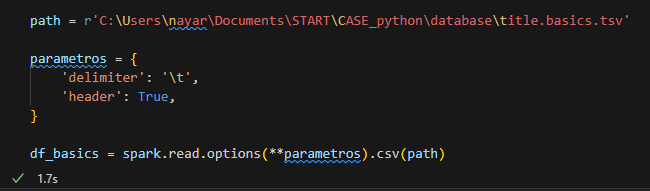

##### Pandas
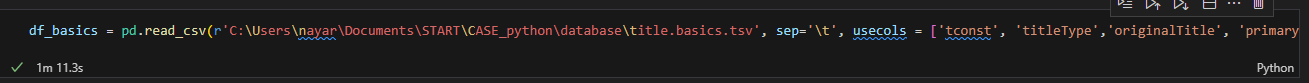

**ANÁLISE**
<p>A análise realizada é considerada relativamente simples, o que facilita sua execução tanto em Pandas quanto em PySpark SQL. No entanto, o PySpark SQL se destaca pela sua simplicidade de uso e compreensão. Uma limitação do PySpark é a ausência de um índice embutido, o que pode ser visto como uma desvantagem em alguns contextos. Além disso, a criação e utilização de funções definidas pelo usuário no PySpark requer um esforço e importação adicional. Apesar dessas limitações, o PySpark SQL é rápido e eficiente, evidenciando sua adaptabilidade e flexibilidade em cenários de análise de dados.</p>


##### PySpark
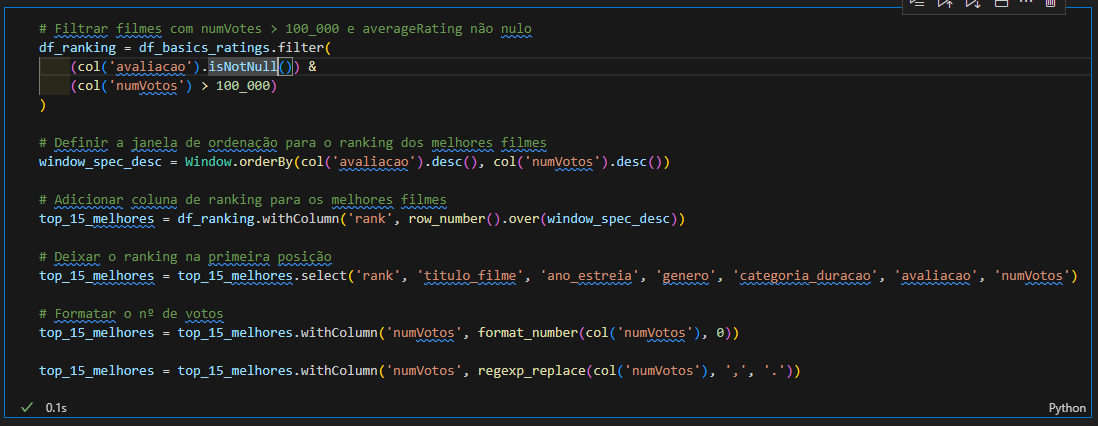

##### PySpark.SQL
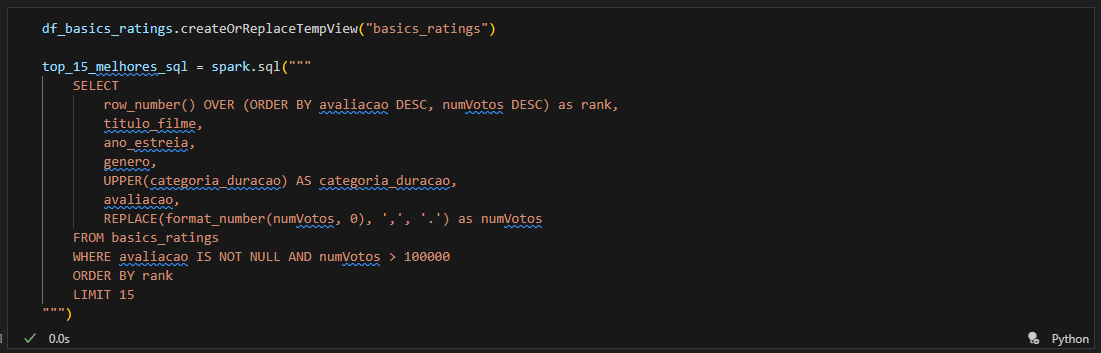

##### Pandas
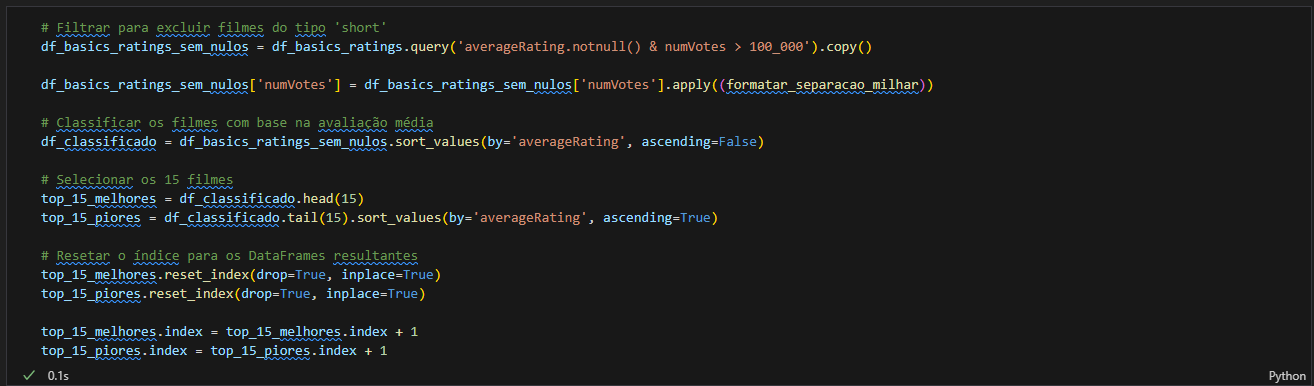


**VISUALIZAÇÃO (SHOW() E PANDAS)**
<p>A visualização de dados no PySpark (.show()) foi mais demorada do que no Pandas (menos de 2 segundos). No PySpark, o processo levou quase 30 segundos, mas como o mesmo é projetado para grande quantidade de dados, isso deve-se ao processamento distribuído e à necessidade de otimização e cache para grandes volumes de dados, enquanto o Pandas opera diretamente na memória, proporcionando resultados mais rápidos para datasets menores.</p>

##### PySpark
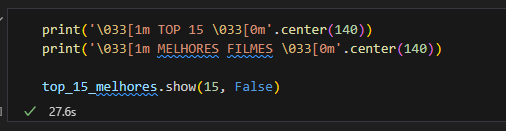

##### PySpark.SQL
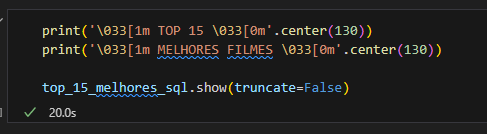

##### Pandas
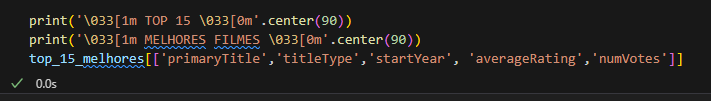

------

<h3 style="color: #191970; font-weight: bold;">ANÁLISE 2</h3>
<p>Existiu diferença de performance entre spark.sql e pyspark puro?</p>

<style>
    p {
        font-size: 14px;
    }
</style>

<p>Para este exercício, a principal distinção está na simplicidade e concisão do código. Enquanto o PySpark puro exige um código mais extenso e complexo, o uso do spark.sql permite uma solução mais compacta e compreensível, reduzindo a complexidade e facilitando a manutenção e o entendimento.</p>

##### PySpark
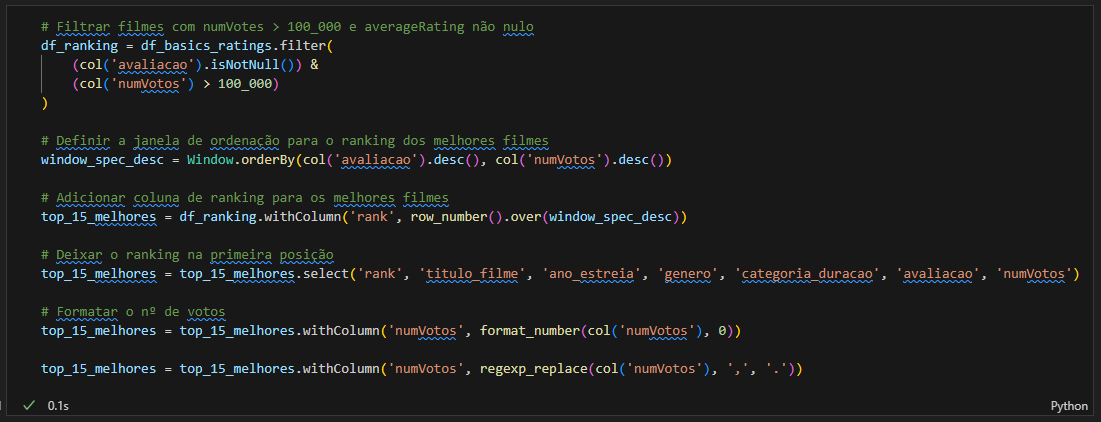

##### PySpark.SQL
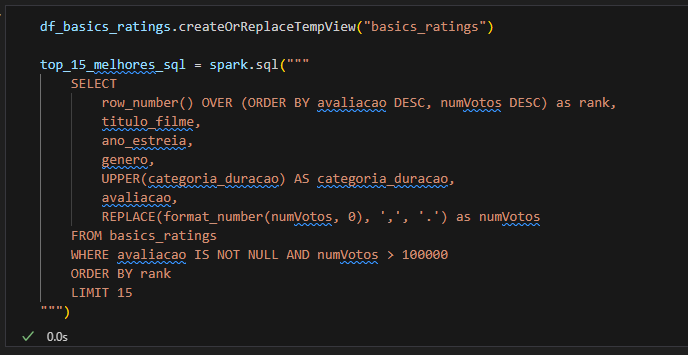

-----

<h3 style="color: #191970; font-weight: bold;">ANÁLISE 3</h3>
<p>É possível otimizar os arquivos? Utilizando outro formato, criando particionamento e etc.</p>

<style>
    p {
        font-size: 14px;
    }
</style>

<p>Para esse exercício não foi necessário utilizar outros formatos de arquivo, mas o PySpark proporciona o uso de formatos de arquivo eficientes e particionamento.</p>

**Formatos de Arquivo**
- <p>CSV: É um formato de arquivo simples que armazena dados em linhas, com cada linha representando uma observação.</p>
- <p>Parquet: Um formato de coluna altamente eficiente que suporta compressão e codificação, ideal para grandes volumes de dados.</p>
- <p>ORC (Optimized Row Columnar): Outro formato de coluna que oferece alta compressão e desempenho rápido para leitura e escrita.</p>
- <p>Avro: É um formato de arquivo colunar e flexível que pode ser usado para armazenar dados estruturados e não estruturados.</p>
- <p>Delta: É um formato de arquivo desenvolvido pela Databricks para lidar com operações de ingestão, atualização e exclusão de dados de forma confiável em ambientes de Big Data.</p>

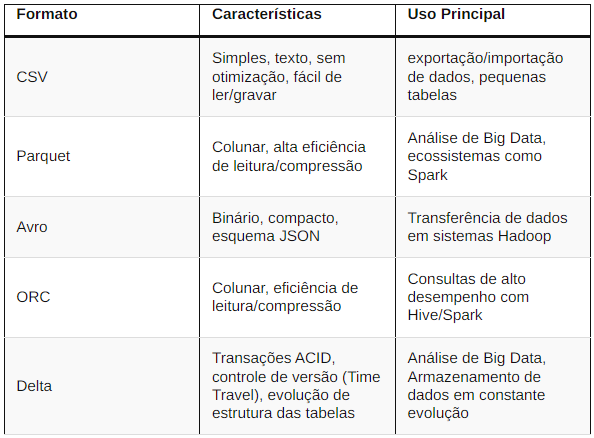

**Particionamento**
- <p>Particionamento por Coluna: Dividir os dados em diferentes arquivos com base em uma ou mais colunas pode melhorar o desempenho de leitura e escrita. Por exemplo, particionar por data ou por região pode reduzir a quantidade de dados lidos durante consultas.</p>
- <p>Particionamento Dinâmico: Usar particionamento dinâmico pode melhorar o desempenho ao escrever dados, dividindo-os automaticamente em diferentes partições com base nos valores das colunas.</p>


<p>Implementar essas práticas pode ajudar a melhorar a eficiência e o desempenho das suas operações de leitura e escrita de dados no PySpark.</p>

-------

<h3 style="color: #191970; font-weight: bold;">ANÁLISE 4</h3>
<p>Faça uma pesquisa sobre particionamento no pyspark e como isso pode impactar na performance para análise de bigdata.</p>

<style>
    p {
        font-size: 14px;
    }
</style>


<p>O particionamento de dados no PySpark é importante para permitir um processamento mais rápido e eficiente, além de ajudar a otimizar o uso de recursos como memória e processamento em paralelo. </p>
    
- <p>Distribuição de carga: quando se trabalha com grandes conjuntos de dados, é comum que o tempo de processamento seja um fator limitante. O particionamento permite distribuir a carga de trabalho entre diferentes nós de processamento, possibilitando um processamento mais rápido e eficiente.</p>
- <p>Paralelismo: ao particionar os dados, o PySpark pode realizar o processamento em paralelo, ou seja, várias tarefas podem ser executadas simultaneamente em diferentes partições dos dados. Isso aumenta significativamente a velocidade do processamento.</p>
- <p>Otimização de memória: o particionamento pode ajudar a otimizar o uso de memória, especialmente quando se trabalha com conjuntos de dados muito grandes. Ao dividir os dados em partições menores, é possível manter apenas os dados necessários em memória em cada nó de processamento, reduzindo a quantidade de dados que precisam ser transferidos pela rede.</p>
- <p>Tunning de performance: o particionamento é uma das técnicas que podem ser usadas para ajustar o desempenho do PySpark. Ao escolher o número e tamanho das partições corretamente, é possível obter uma melhora significativa na performance da aplicação.</p>

<p>Pode ser feito de várias maneiras, como por exemplo, através da leitura de arquivos em diferentes formatos, como CSV, JSON ou parquet, ou através  de  DataFrames. Por exemplo, se você estiver trabalhando com um arquivo CSV grande e quiser dividi-lo em 4 partições, você pode fazer o seguinte:</p>

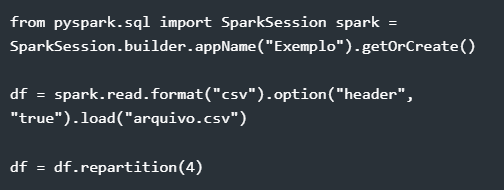

<p>O PySpark também oferece uma forma eficiente de particionar dados no output por meio da função `partitionBy()`. Essa abordagem permite a geração de pastas distintas para cada valor de partição, proporcionando consultas mais eficientes e otimizando a leitura dos dados particionados.</p>
<p>
A função `partitionBy()` do PySpark possibilita a escrita de dados particionados, gerando pastas distintas para cada valor de partição, o que contribui para a organização e otimização das consultas.
A leitura de dados particionados no PySpark, ao informar a coluna de partição, permite que o Spark reconheça a organização física dos dados por partição, otimizando a leitura e o processamen</p>

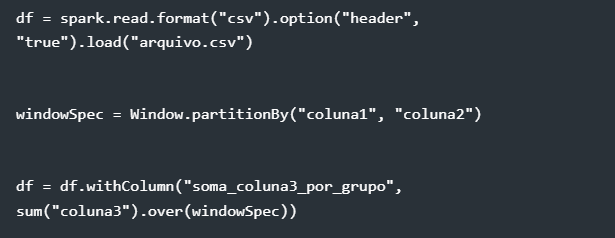

**Saída**

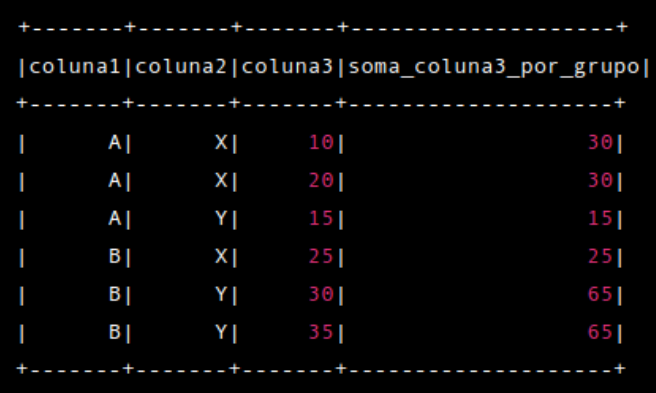





**ATENÇÃO** 
<p>É importante lembrar que o particionamento de dados pode afetar o desempenho de um aplicativo PySpark. Se o número de partições for muito baixo, pode haver gargalos de desempenho durante o processamento de dados. Por outro lado, se o número de partições for muito alto, pode haver overheads de comunicação entre as partições. Por isso, é importante encontrar um equilíbrio adequado entre o número de partições e o tamanho dos dados processados em cada partição.</p>

Informações coletadas dos sites:
- https://www.linkedin.com/pulse/4-aumentando-performance-de-busca-com-partition-pyspark-suhete/
- https://medium.com/@nicholas.comuni/spark-paralelismo-e-particionamento-b64d7dd017db
- https://www.escoladnc.com.br/blog/escrita-de-dados-com-pyspark-guia-pratico-e-eficiente/